# Training Attempt 2


In [1]:
import os
from typing import List, Dict, Tuple
import functools

import librosa
import librosa.display
from librosa.core import load
import numpy as np
import IPython.display as ipd
import ipywidgets as ipw
from sklearn import metrics
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchaudio
torchaudio.set_audio_backend("sox_io")
import pandas as pd
from tqdm import tqdm

from beat2d import settings

/home/jason/miniconda3/envs/beat2d/lib/python3.7/site-packages/torchaudio/backend/utils.py:54: UserWarning: "sox" backend is being deprecated. The default backend will be changed to "sox_io" backend in 0.8.0 and "sox" backend will be removed in 0.9.0. Please migrate to "sox_io" backend. Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  '"sox" backend is being deprecated. '


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [4]:
DATASET_PATH = "../data/oneshots"
CLASSES = {"none": 0, "kick": 1, "snare": 2, "hat": 3}

In [5]:
def play(path: str, sr: int = settings.SAMPLE_RATE):
    s, _ = load(path, sr)
    return ipd.Audio(s, rate=settings.SAMPLE_RATE)

# Dataset

## Loading the Dataset

In [6]:
df = pd.read_csv("../data/oneshots/_labels.csv")

## Labelling the Data

In [14]:
def label_step(df: pd.DataFrame, index=0, recursive=True, unlabelled_only=False):
    ipd.clear_output()

    if index - 1 >= df.oneshot.count():
        print("Done labelling")
        return
    
    if unlabelled_only:
        while True:
            try:
                if not pd.isna(df.label[index]):
                    break
            except:
                pass
            
            if index - 1 >= df.oneshot.count():
                print("Done labelling")
                return
            
            index += 1
            
            

        label_step(df, index+1, recursive, unlabelled_only)
        return
    
    oneshot = df.oneshot[index]
    audio, sr = librosa.core.load("../" + oneshot, settings.SAMPLE_RATE)
    
    if audio.shape[0] < 1:
        return
    
    print(f"index: {index}, id: {df.id[index]}, file: {oneshot}\nlabel: {df.label[index]}")
    ipd.display(ipd.Audio(audio, rate=settings.SAMPLE_RATE, autoplay=True))

    buttons = []
    
    back_btn = ipw.Button(description="back")
    back_btn.on_click(lambda _: label_step(df, index-1, recursive))
    buttons.append(back_btn)
    
    for cls in CLASSES:
        def cb(label, *args):
            df.loc[index, "label"] = label
            label_step(df, index+1)
        
        btn = ipw.Button(description=cls)
        btn.on_click(functools.partial(cb, cls))
        buttons.append(btn)
    
    next_btn = ipw.Button(description="next")
    next_btn.on_click(lambda _: label_step(df, index+1, recursive))
    buttons.append(next_btn)
    
    ipd.display(ipw.HBox(buttons))

In [15]:
label_step(df, unlabelled_only=True)

Done labelling


In [16]:
df.label.value_counts()

hat      266
none     190
kick     157
snare    139
Name: label, dtype: int64

In [17]:
# Commented so we don't overwrite it
# df.to_csv("../data/oneshots/_labels.csv")

In [18]:
dataset = pd.read_csv("../data/oneshots/_labels.csv")

First I want to take a look at the average length of samples.

In [19]:
dataset.length = dataset.oneshot.apply(lambda o: (
    librosa.get_duration(librosa.core.load("../" + o, sr=settings.SAMPLE_RATE)[0], settings.SAMPLE_RATE)
))

In [20]:
dataset.length.describe()

count    752.000000
mean       0.474068
std        0.339103
min        0.046440
25%        0.301859
50%        0.394739
75%        0.580499
max        4.504671
Name: length, dtype: float64

Text(0, 0.5, 'Number of Samples')

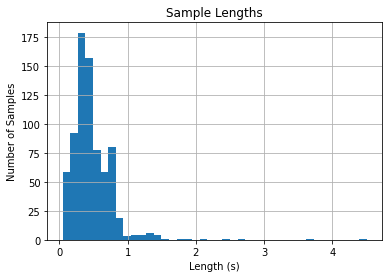

In [21]:
ax = dataset.length.hist(bins=40)
ax.set_title("Sample Lengths")
ax.set_xlabel("Length (s)")
ax.set_ylabel("Number of Samples")

# Computing Features

Next we'll use torchaudio to generate our features from the audio. I chose to use MEL Spectrograms to transform my data into another feature space.

In [22]:
def mel_spectrogram_layer(sr: int = settings.SAMPLE_RATE):
    return torchaudio.transforms.MelSpectrogram(
        sample_rate=sr,
        n_mels=70,
        normalized=True,
        n_fft=800
    )

def compute_features(sample: np.ndarray, sr: int = settings.SAMPLE_RATE):
    return mel_spectrogram_layer()(torch.from_numpy(sample))

Now I'll get a list of each track.

In [23]:
nones = dataset[dataset.label == "none"]
kicks = dataset[dataset.label == "kick"]
snares = dataset[dataset.label == "snare"]
hats = dataset[dataset.label == "hat"]

Text(0.5, 1.0, 'hat')

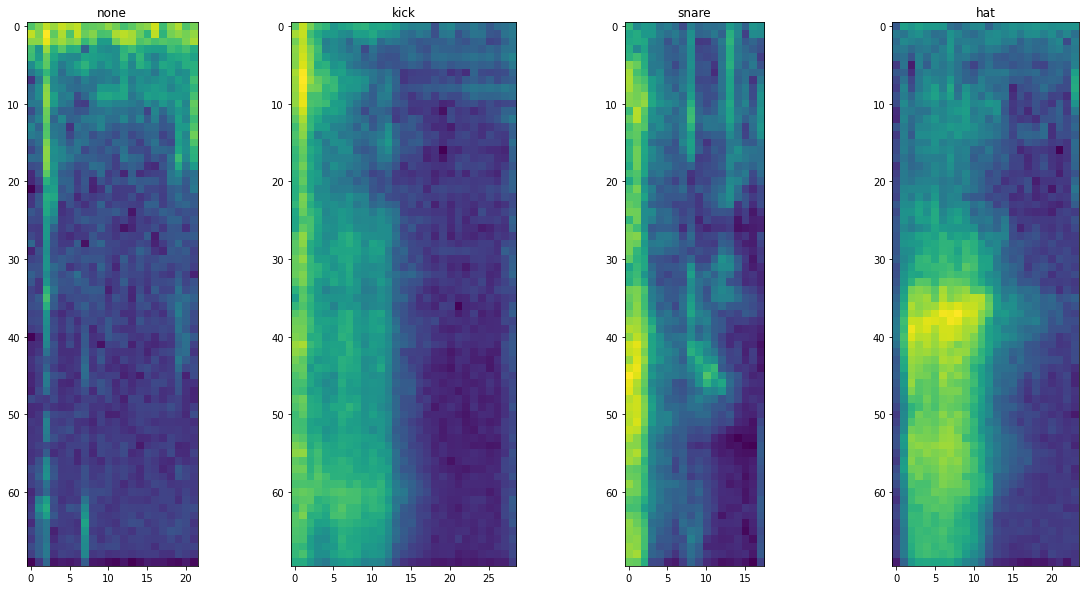

In [114]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=1, ncols=4, figsize=(20, 10))

s = load("../" + nones.sample(1).iloc[0].oneshot, settings.SAMPLE_RATE)[0]
melspec = compute_features(s, settings.SAMPLE_RATE)
ax1.imshow(melspec.log2().detach().numpy())
ax1.set_title("none")
                                    
s = load("../" + kicks.sample(1).iloc[0].oneshot, settings.SAMPLE_RATE)[0]
melspec = compute_features(s, settings.SAMPLE_RATE)
ax2.imshow(melspec.log2().detach().numpy())
ax2.set_title("kick")

s = load("../" + snares.sample(1).iloc[0].oneshot, settings.SAMPLE_RATE)[0]
melspec = compute_features(s, settings.SAMPLE_RATE)
ax3.imshow(melspec.log2().detach().numpy())
ax3.set_title("snare")

s = load("../" + hats.sample(1).iloc[0].oneshot, settings.SAMPLE_RATE)[0]
melspec = compute_features(s, settings.SAMPLE_RATE)
ax4.imshow(melspec.log2().detach().numpy())
ax4.set_title("hat")

A human could probably identify each type of sample using the Mel Spectrogram, so our model should be pretty good at it too!

# Preprocessing Data

There's a couple things we need to do to preprocess our data before our model sees it:

1. Normalize the audio sample
2. Trim the sample to relevant audio
3. Crop or pad the sample to 0.5 seconds (11025 samples)

In [25]:
# We'll use this sample for all our preprocessing steps
# idx = 30
# idx = 55
idx = 238

s = load("../" + dataset.iloc[idx].oneshot, settings.SAMPLE_RATE)[0]

print(dataset.iloc[idx].label)

ipd.Audio(s, rate=settings.SAMPLE_RATE)

snare


## Normalizing

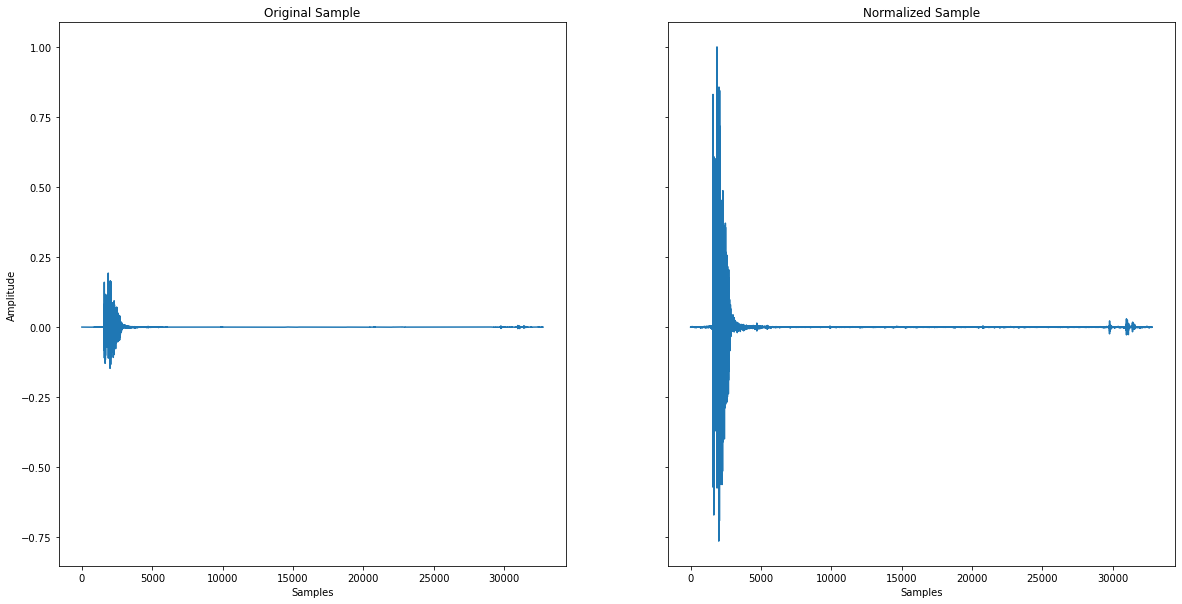

In [26]:
s_norm = librosa.util.normalize(s)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20, 10), sharey=True)

ax1.set_title("Original Sample")
ax1.set_ylabel("Amplitude")
ax1.set_xlabel("Samples")
ax1.plot(s)

ax2.set_title("Normalized Sample")
ax2.set_xlabel("Samples")
ax2.plot(s_norm)

## Trimming the Start and End

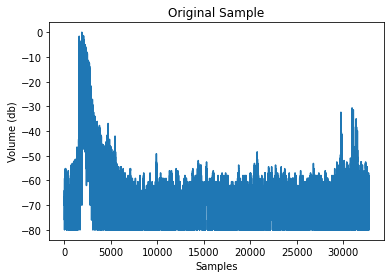

In [27]:
ax = plt.gca()

ax.set_title("Original Sample")
ax.set_ylabel("Volume (db)")
ax.set_xlabel("Samples")
ax.plot(librosa.core.amplitude_to_db(s_norm))

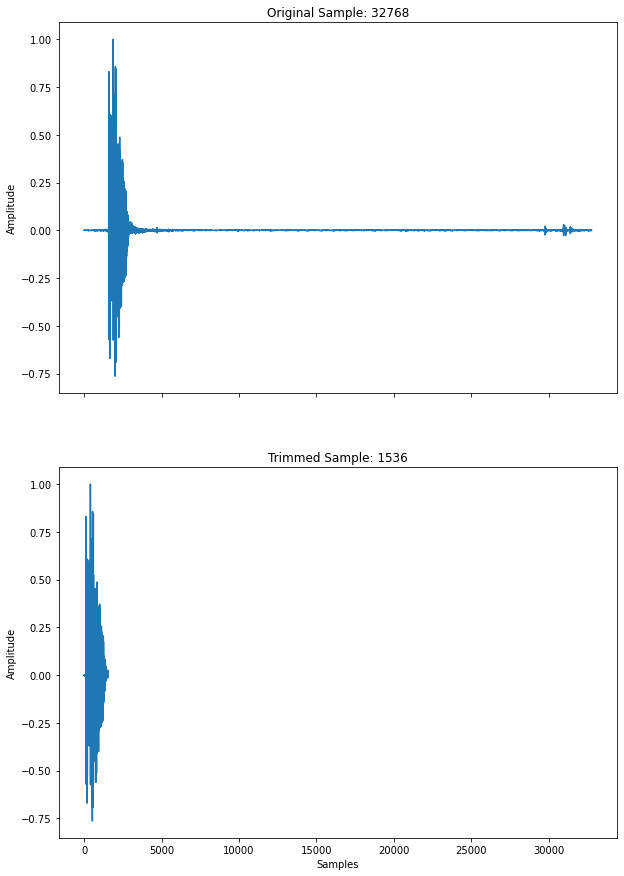

In [28]:
s_trim, trim_pts = librosa.effects.trim(s_norm, frame_length=256, hop_length=64, top_db=25)

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(10, 15), sharex=True)

ax1.set_title(f"Original Sample: {s_norm.shape[0]}")
ax1.set_ylabel("Amplitude")
ax1.plot(s_norm)

ax2.set_title(f"Trimmed Sample: {s_trim.shape[0]}")
ax2.set_ylabel("Amplitude")
ax2.set_xlabel("Samples")
ax2.plot(s_trim)

In [29]:
trimmed_lengths = dataset.oneshot.apply(lambda o: (
    librosa.get_duration(librosa.effects.trim(librosa.util.normalize(librosa.core.load("../" + o, sr=settings.SAMPLE_RATE)[0]), frame_length=256, hop_length=64, top_db=20)[0], settings.SAMPLE_RATE)
))

In [30]:
trimmed_lengths.describe()

count    752.000000
mean       0.201843
std        0.234802
min        0.005805
25%        0.081270
50%        0.145125
75%        0.232200
max        3.715193
Name: oneshot, dtype: float64

<AxesSubplot:>

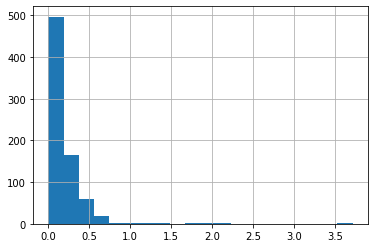

In [31]:
trimmed_lengths.hist(bins=20)

From this, I'm comfortable clipping at 0.2 seconds.

## Clipping and Padding to 0.2 Seconds

In [32]:
max_clip_length = librosa.core.time_to_samples(0.2)

In [33]:
s_dest = np.zeros(max_clip_length, dtype=np.float32)

clip_length = min(max_clip_length, s_trim.shape[0])
s_dest[:clip_length] = s_trim[:clip_length]

In [34]:
compute_features(s_dest).shape

torch.Size([70, 12])

torch.Size([70, 12])


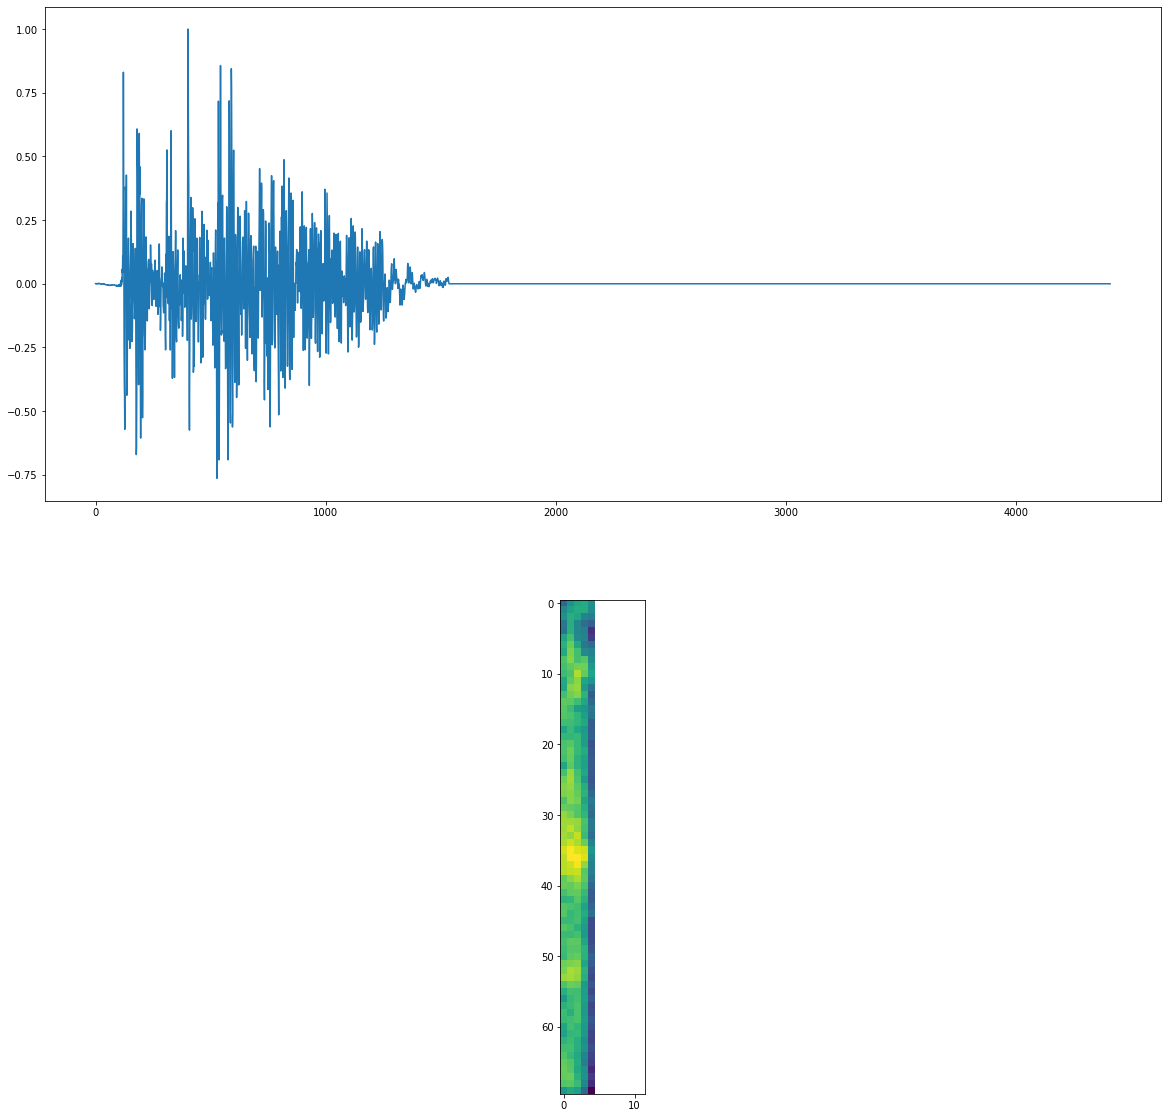

In [35]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(20, 20))

melspec = compute_features(s_dest)
print(melspec.shape)

ax1.plot(s_dest)
ax2.imshow(melspec.log2().detach().numpy())

## Combining it into One Function

In [36]:
MAX_CLIP_LENGTH = librosa.core.time_to_samples(0.2)

def preprocess_sample(sample: np.ndarray):
    # Normalize the audio
    s_norm = librosa.util.normalize(sample)
    
    # Trim silence
    s_trim = librosa.effects.trim(s_norm, frame_length=256, hop_length=64, top_db=25)[0]
    
    # Clip or pad to MAX_CLIP_LENGTH
    s_dest = np.zeros(MAX_CLIP_LENGTH, dtype=np.float32)
    clip_length = min(MAX_CLIP_LENGTH, s_trim.shape[0])
    s_dest[:clip_length] = s_trim[:clip_length]
    
    return s_dest

MAX_CLIP_LENGTH2 = librosa.core.time_to_samples(0.4)

def preprocess_sample2(sample: np.ndarray):
    # Normalize the audio
    s_norm = librosa.util.normalize(sample)
    
    # Trim silence
    s_trim = librosa.effects.trim(s_norm, frame_length=256, hop_length=64, top_db=25)[0]
    
    # Clip or pad to MAX_CLIP_LENGTH
    s_dest = np.zeros(MAX_CLIP_LENGTH2, dtype=np.float32)
    clip_length = min(MAX_CLIP_LENGTH2, s_trim.shape[0])
    s_dest[:clip_length] = s_trim[:clip_length]
    
    return s_dest

In [37]:
MAX_CLIP_LENGTH2

8820

# Building our Model

In [133]:
class NetV1(nn.Module):

    def __init__(self):
        super().__init__()
        self.melspec = torchaudio.transforms.MelSpectrogram(
            sample_rate=settings.SAMPLE_RATE,
            n_mels=70,
            normalized=True
        )
        self.conv1 = nn.Conv2d(1, 6, 3)
        self.conv2 = nn.Conv2d(6, 16, 3)

        self.fc1 = nn.Linear(16 * 16 * 9, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 3)

    def forward(self, x):
        x = self.melspec(x)
        print(x.shape)
        x = F.max_pool2d(F.relu(self.conv1(x)), 2)
        print(x.shape)
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        print(x.shape)
        x = x.view(-1, 16 * 16 * 9)
        
        x = F.relu(self.fc1(x))
        x = F.dropout(x, 0.2)
        x = F.relu(self.fc2(x))
        x = F.dropout(x, 0.2)
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        
        return x
    
    def predict(self, x):
        x = self.forward(x)
        
        return int(F.softmax(x, dim=1).argmax())
    

class NetV2(nn.Module):

    def __init__(self):
        super().__init__()
        self.melspec = torchaudio.transforms.MelSpectrogram(
            sample_rate=settings.SAMPLE_RATE,
            n_mels=128,
            n_fft=800,
            normalized=True
        )
        self.conv1 = nn.Conv2d(1, 6, 3)
        self.conv2 = nn.Conv2d(6, 16, 3)

        self.fc1 = nn.Linear(16 * 30 * 4, 960)
        self.fc2 = nn.Linear(960, 480)
        self.fc3 = nn.Linear(480, 240)
        self.fc4 = nn.Linear(240, 4)

    def forward(self, x):
        x = self.melspec(x)
        x = F.max_pool2d(F.relu(self.conv1(x)), 2)
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, 16 * 30 * 4)
        
        
        x = F.relu(self.fc1(x))
        x = F.dropout(x, 0.2)
        x = F.relu(self.fc2(x))
        x = F.dropout(x, 0.2)
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        
        return x
    
    def predict(self, x):
        x = self.forward(x)
        
        return int(F.softmax(x, dim=1).argmax())

In [134]:
net = NetV1().to(device)

In [135]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.0001, weight_decay=0.001)

# Preparing Training Data

In [136]:
class BeatboxDataset(torch.utils.data.Dataset):
    def __init__(self, df: pd.DataFrame):
        self.df = df
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        row = self.df.iloc[idx]
        
        waveform = load("../" + row.oneshot, settings.SAMPLE_RATE)[0]
        waveform = preprocess_sample(waveform)
        
        waveform_tensor = torch.from_numpy(waveform).view(1, 4410)
        
        return waveform_tensor.to(device), CLASSES[row.label]

    
class BeatboxDataset2(torch.utils.data.Dataset):
    def __init__(self, df: pd.DataFrame):
        self.df = df
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        row = self.df.iloc[idx]
        
        waveform = load("../" + row.oneshot, settings.SAMPLE_RATE)[0]
        waveform = preprocess_sample2(waveform)
        
        waveform_tensor = torch.from_numpy(waveform).view(1, 8820)
        
        return waveform_tensor.to(device), CLASSES[row.label] - 1

In [137]:
train, test = train_test_split(dataset, test_size=0.25, shuffle=True)

In [138]:
train[train.label != "none"]

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,Unnamed: 0.1.1.1,id,oneshot,source,start,end,label,length
508,508,510,510,510,PzbSNF5CHoPiK5Nd8NnTvh,data/oneshots/PzbSNF5CHoPiK5Nd8NnTvh.wav,data/recordings/all.wav,2151936,2160640,kick,0.394739
201,201,201,201,201,ByAt387i4NSDQz6nhXDv2J,data/oneshots/ByAt387i4NSDQz6nhXDv2J.wav,../data/recordings/snare.wav,806912,812544,snare,0.255420
351,351,353,353,353,Y4VNT9yMPHshDAJBgahzQy,data/oneshots/Y4VNT9yMPHshDAJBgahzQy.wav,data/recordings/all.wav,839168,846848,kick,0.348299
491,491,493,493,493,S99ELQNrX7iDQZh5fHXTcp,data/oneshots/S99ELQNrX7iDQZh5fHXTcp.wav,data/recordings/all.wav,2023424,2031616,kick,0.371519
98,98,98,98,98,8VXxxgypSxMexEUi2tEjBU,data/oneshots/8VXxxgypSxMexEUi2tEjBU.wav,../data/recordings/kicks.wav,921600,934400,kick,0.580499
...,...,...,...,...,...,...,...,...,...,...,...
420,420,422,422,422,Na52axc78FBQZ4ZxAMyJJT,data/oneshots/Na52axc78FBQZ4ZxAMyJJT.wav,data/recordings/all.wav,1449472,1459200,kick,0.441179
521,521,523,523,523,BZLcoMU6cbjNv6Fkqnt2qw,data/oneshots/BZLcoMU6cbjNv6Fkqnt2qw.wav,data/recordings/all.wav,2258432,2266112,hat,0.348299
39,39,39,39,39,76bNjjTJYEpwEB5VpeYqLz,data/oneshots/76bNjjTJYEpwEB5VpeYqLz.wav,../data/recordings/kicks.wav,304128,316416,kick,0.557279
535,535,537,537,537,Y5Bj3io5rEoc2TFGMuKPpE,data/oneshots/Y5Bj3io5rEoc2TFGMuKPpE.wav,data/recordings/hats.wav,24576,31744,hat,0.325079


In [139]:
train_set = BeatboxDataset2(train[train.label != "none"])
train_dataloader = torch.utils.data.DataLoader(train_set, batch_size=8, shuffle=True)

test_set = BeatboxDataset2(test[test.label != "none"])
test_dataloader = torch.utils.data.DataLoader(test_set, batch_size=8)

In [140]:
data, label = next(iter(train_dataloader))

example_forward = net.forward(data[0].unsqueeze(0))

torch.Size([1, 1, 70, 45])
torch.Size([1, 6, 34, 21])
torch.Size([1, 16, 16, 9])


In [124]:
class Metric:
    def __init__(self, evaluation_func):
        self.evaluation_func = evaluation_func
        
        self.last = 0.0
        self.epoch_history = []
        self.history = []
        self.min = float('inf')
        self.max = 0.0
    
    def update(self, labels, predictions):
        val = float(self.evaluation_func(labels, predictions))
        self.epoch_history.append(val)
        
    def epoch_start(self):
        if len(self.epoch_history) > 0:
            epoch_val = np.mean(self.epoch_history)

            self.min = min(self.min, epoch_val)
            self.max = max(self.max, epoch_val)
            self.history.append(epoch_val)
            self.last = epoch_val

            self.epoch_history = []
        

class Evaluator:
    def __init__(self, metrics_dict):
        self.metrics = metrics_dict
    
    def update(self, labels, predictions):
        for metric in self.metrics.values():
            metric.update(labels, predictions)
    
    def epoch_start(self):
        for metric in self.metrics.values():
            metric.epoch_start()
    
    def metrics_string(self):
        output = ""
        for name, metric in self.metrics.items():
            output += f"{name}: {metric.last:04f} "
        return output
    

class EarlyStopping:
    def __init__(self, patience):
        self.patience = patience
        self.counter = 0
    
    def reset(self):
        self.counter = 0
    
    def should_stop(self):
        self.counter += 1
        if self.counter >= self.patience:
            return True
        return False

In [101]:
def train_epoch(dataloader: torch.utils.data.DataLoader, evaluator: Evaluator):
    total_loss = 0.0
    for batch_i, (inputs, labels) in enumerate(dataloader):
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        
        optimizer.step()
        
        total_loss += loss.item()
        
        evaluator.update(labels.cpu(), outputs.cpu())
    
    return total_loss / len(dataloader)

In [102]:
epochs = 200
early_stop = EarlyStopping(10)

train_evaluator = Evaluator({
    "loss": Metric(lambda labels, preds: nn.CrossEntropyLoss()(preds, labels)),
    "acc": Metric(lambda labels, preds: metrics.accuracy_score(labels, [int(p.argmax()) for p in preds.detach().numpy()])),
    "prec": Metric(lambda labels, preds: metrics.precision_score(labels, [int(p.argmax()) for p in preds.detach().numpy()], average="weighted")),
    "recall": Metric(lambda labels, preds: metrics.recall_score(labels, [int(p.argmax()) for p in preds.detach().numpy()], average="weighted")),
    "f1": Metric(lambda labels, preds: metrics.f1_score(labels, [int(p.argmax()) for p in preds.detach().numpy()], average="weighted"))
})

val_evaluator = Evaluator({
    "loss": Metric(lambda labels, preds: nn.CrossEntropyLoss()(preds, labels)),
    "acc": Metric(lambda labels, preds: metrics.accuracy_score(labels, [int(p.argmax()) for p in preds.detach().numpy()])),
    "prec": Metric(lambda labels, preds: metrics.precision_score(labels, [int(p.argmax()) for p in preds.detach().numpy()], average="weighted")),
    "recall": Metric(lambda labels, preds: metrics.recall_score(labels, [int(p.argmax()) for p in preds.detach().numpy()], average="weighted")),
    "f1": Metric(lambda labels, preds: metrics.f1_score(labels, [int(p.argmax()) for p in preds.detach().numpy()], average="weighted"))
})

for i in range(epochs):
    print("Epoch", i)
    
    train_evaluator.epoch_start()
    
    net.train()
    train_loss = train_epoch(train_dataloader, train_evaluator)
    
    print(f"Training:  ", train_evaluator.metrics_string())
    
    net.eval()
    test_loss = 0.0
    
    val_evaluator.epoch_start()
    
    with torch.no_grad():
        for inputs, labels in test_dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = net(inputs)
            
            loss = criterion(outputs, labels)
            
            val_evaluator.update(labels.cpu(), outputs.cpu())
            
    print(f"Validation:", val_evaluator.metrics_string())
    
    if val_evaluator.metrics["loss"].last > val_evaluator.metrics["loss"].min:
        if early_stop.should_stop():
            print("Early Stopping")
            break
    else:
        print("Saving new best")
        early_stop.reset()
        model_name = f"model_epoch-{i}_tl-{train_evaluator.metrics['loss'].last:.3f}_vl-{val_evaluator.metrics['loss'].last:.3f}"
        torch.save(net.state_dict(), f"{model_name}.pth")
        print(model_name)

Epoch 0


/home/jason/miniconda3/envs/beat2d/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training:   loss: 0.000000 acc: 0.000000 prec: 0.000000 recall: 0.000000 f1: 0.000000 
Validation: loss: 0.000000 acc: 0.000000 prec: 0.000000 recall: 0.000000 f1: 0.000000 
Saving new best
model_epoch-0_tl-0.000_vl-0.000
Epoch 1
Training:   loss: 1.025961 acc: 0.475629 prec: 0.251802 recall: 0.475629 f1: 0.322949 
Validation: loss: 0.889863 acc: 0.479167 prec: 0.315848 recall: 0.479167 f1: 0.344818 
Saving new best
model_epoch-1_tl-1.026_vl-0.890
Epoch 2


/home/jason/miniconda3/envs/beat2d/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training:   loss: 0.717009 acc: 0.669811 prec: 0.608653 recall: 0.669811 f1: 0.594316 
Validation: loss: 0.531589 acc: 0.861111 prec: 0.833391 recall: 0.861111 f1: 0.831335 
Saving new best
model_epoch-2_tl-0.717_vl-0.532
Epoch 3
Training:   loss: 0.430026 acc: 0.915094 prec: 0.934513 recall: 0.915094 f1: 0.914283 
Validation: loss: 0.307289 acc: 0.930556 prec: 0.948495 recall: 0.930556 f1: 0.928171 
Saving new best
model_epoch-3_tl-0.430_vl-0.307
Epoch 4
Training:   loss: 0.270392 acc: 0.933962 prec: 0.963325 recall: 0.933962 f1: 0.935700 
Validation: loss: 0.193594 acc: 0.930556 prec: 0.959491 recall: 0.930556 f1: 0.931180 
Saving new best
model_epoch-4_tl-0.270_vl-0.194
Epoch 5
Training:   loss: 0.232244 acc: 0.939465 prec: 0.954245 recall: 0.939465 f1: 0.938079 
Validation: loss: 0.163658 acc: 0.944444 prec: 0.956597 recall: 0.944444 f1: 0.941597 
Saving new best
model_epoch-5_tl-0.232_vl-0.164
Epoch 6
Training:   loss: 0.199623 acc: 0.931604 prec: 0.958294 recall: 0.931604 f1: 0.9

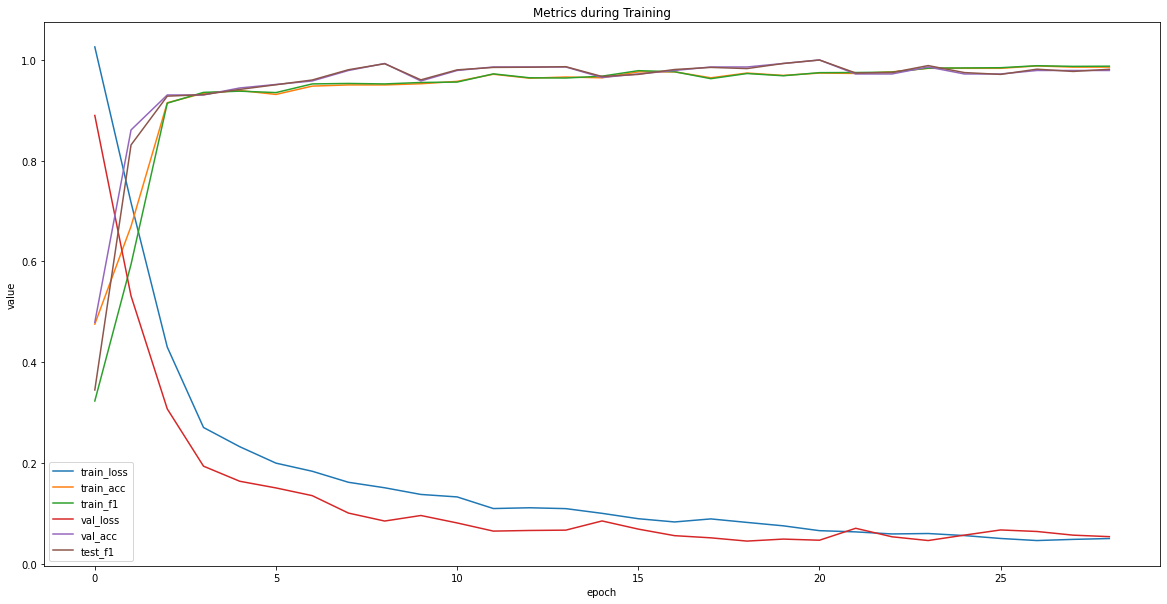

In [105]:
fig, ax = plt.subplots(figsize=(20, 10))

ax.set_facecolor("white")

ax.set_title("Metrics during Training")
ax.set_xlabel("epoch")
ax.set_ylabel("value")

ax.plot(train_evaluator.metrics["loss"].history, label="train_loss")
ax.plot(train_evaluator.metrics["acc"].history, label="train_acc")
ax.plot(train_evaluator.metrics["f1"].history, label="train_f1")

ax.plot(val_evaluator.metrics["loss"].history, label="val_loss")
ax.plot(val_evaluator.metrics["acc"].history, label="val_acc")
ax.plot(val_evaluator.metrics["f1"].history, label="test_f1")

ax.legend()

In [106]:
torch.save(net.state_dict(), "../model-final.pth")

In [187]:
# To load into memory
# model = Net()
# model.load_state_dict(torch.load("../models/model.pth"))
# model.eval()

In [107]:
fpath = "../" + df[df.label == "none"].sample(1).iloc[0].oneshot
test_sample_waveform, tsr = load(fpath, settings.SAMPLE_RATE)
test_sample = preprocess_sample2(test_sample_waveform)

In [108]:
test_sample = torch.tensor(test_sample).view(1, 1, 8820)

In [109]:
torch.set_printoptions(precision=4, sci_mode=False)

In [112]:
x = F.softmax(net.forward(test_sample.to(device)), dim=1)
print(x.argmax())

tensor(1, device='cuda:0')


In [287]:
ipd.Audio(test_sample_waveform, rate=settings.SAMPLE_RATE)

# Testing our Final Model

In [188]:
from beat2d import model

In [189]:
m = model.load_model()

AttributeError: module 'beat2d.model' has no attribute 'load_model'

In [ ]:
dataset.loc[dataset.id == "Q7gFWKMVBsFBQ47WW5qhFA"]

In [ ]:
def predict_play_random_example(df: pd.DataFrame, m: model.Model, label: str, sr: int = settings.SAMPLE_RATE):
    ex = test[test.label == label].sample(1).iloc[0]
    
    X, sr = load(ex.oneshot, settings.SAMPLE_RATE)

    pred = m.predict(X)

    print(ex.id, pred, ex.label)

    ipd.display(ipd.Audio(X, rate=settings.SAMPLE_RATE))

In [ ]:
predict_play_random_example(test, m, "none")

In [ ]:
predict_play_random_example(test, m, "kick")

In [ ]:
predict_play_random_example(test, m, "snare")

# Testing with iPhone Recordings

Using a totally different microphone and environment, I want to see if our model can handle the change in data.

The main steps we have to go to go from recording to MIDI are:

1. Split the audio by onsets
2. Predict the class of each oneshot
3. Transform the timestamp, amplitude, and label information to MIDI

In [ ]:
from beat2d import slicing

In [ ]:
m = model.load_model()

In [ ]:
s, sr = load("../data/test/iphone01.m4a", settings.SAMPLE_RATE)
ipd.Audio(s, rate=sr)

In [ ]:
slices, slice_pts = slicing.split_oneshots(s, sr)

In [ ]:
for slc in slices:
    pred = net.predict(slc)
    print(pred)
    ipd.display(ipd.Audio(slc, rate=sr))
    input()
    ipd.clear_output()

In [ ]:
s, sr = load("../data/test/iphone02.m4a", settings.SAMPLE_RATE, )
ipd.display(ipd.Audio(s, rate=sr))

slices, slice_pts = slicing.split_oneshots(s, sr)

In [ ]:
for slc in slices:
    pred = m.predict(slc)
    print(pred)
    ipd.display(ipd.Audio(slc, rate=sr))
    input()
    ipd.clear_output()